# 🛒 E-Commerce Analytics Project (Pandas + PySpark)
---
This notebook performs data analysis on `ecommerce_sample500.csv`, replicating the structure of the *Employees Office Data Analytics* PDF.

**Steps Covered:**
1. Import libraries
2. Load and explore dataset
3. Perform Pandas-based EDA
4. Visualization with Matplotlib
5. PySpark-based distributed analytics
6. Export results


In [1]:

import os
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as _sum, avg as _avg, countDistinct, to_date


In [2]:

# Load dataset
csv_path = "ecommerce_sample500.csv"  # Update path if needed
df = pd.read_csv(csv_path)

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

# Add computed column
df['Revenue'] = df['Quantity'] * df['UnitPrice']

df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,25795,1417,Watch,2,2022-01-01,303.59,10007,USA,607.18
1,10860,9306,Bag,8,2022-01-02,171.93,10919,United Kingdom,1375.44
2,86820,9808,Bag,3,2022-01-03,453.23,10507,United Kingdom,1359.69
3,64886,4974,Shoes,3,2022-01-04,387.45,10475,Spain,1162.35
4,16265,4267,Watch,8,2022-01-05,136.12,10296,France,1088.96


In [3]:

print("Dataset shape:", df.shape)
print("\nMissing values per column:\n", df.isnull().sum())
print("\nBasic statistics:\n", df.describe(include='number').T)


Dataset shape: (500, 9)

Missing values per column:
 InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
Revenue        0
dtype: int64

Basic statistics:
             count         mean           std       min         25%        50%  \
InvoiceNo   500.0  55825.00600  26748.293127  10206.00  32596.2500  58379.000   
StockCode   500.0   5560.13000   2553.722015   1005.00   3237.0000   5738.500   
Quantity    500.0      4.93400      2.615210      1.00      3.0000      5.000   
UnitPrice   500.0    245.41798    141.655875      5.16    117.7275    244.145   
CustomerID  500.0  10534.06000    278.172465  10000.00  10299.0000  10549.500   
Revenue     500.0   1229.36278   1032.802466      5.16    363.3825    919.375   

                   75%       max  
InvoiceNo   77983.5000  99912.00  
StockCode    7834.5000   9989.00  
Quantity        7.0000      9.00  
UnitPrice     372.2275    497.76  
CustomerID  10775.

In [4]:

# Basic KPIs
total_orders = df['InvoiceNo'].nunique()
unique_customers = df['CustomerID'].nunique()
total_revenue = df['Revenue'].sum()
avg_order_value = df.groupby('InvoiceNo')['Revenue'].sum().mean()

print(f"Total Orders: {total_orders}\nUnique Customers: {unique_customers}\nTotal Revenue: {total_revenue:.2f}\nAOV: {avg_order_value:.2f}")

# Top products by revenue
top_products = df.groupby(['StockCode','Description'])['Revenue'].sum().reset_index().sort_values('Revenue', ascending=False)
top_products.head(10)


Total Orders: 500
Unique Customers: 390
Total Revenue: 614681.39
AOV: 1229.36


,StockCode,Description,Revenue
275,6124,T-Shirt,6319.04
485,9702,Watch,4309.83
477,9567,T-Shirt,4155.30
151,3824,Shoes,4096.35
361,7588,Shoes,4046.76
364,7677,Bag,3861.92
218,5186,Shoes,3813.04
381,7941,Watch,3808.53
494,9905,Headphones,3721.23
228,5300,Laptop,3716.16


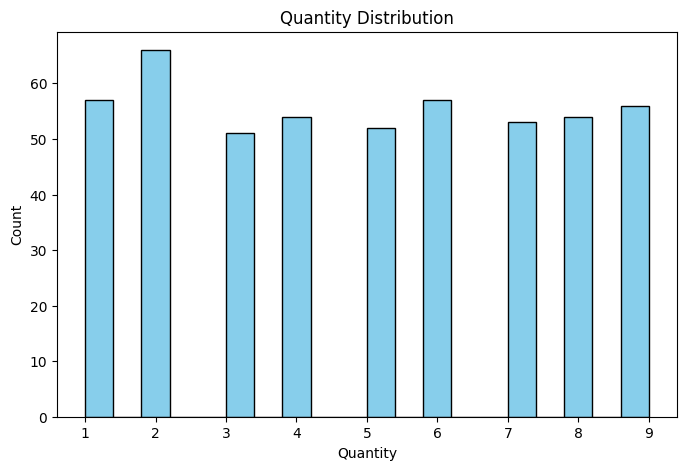

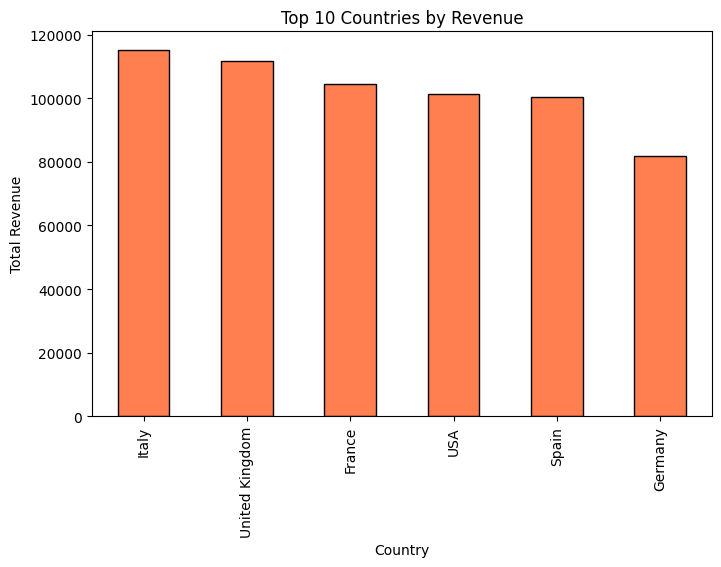

In [5]:

out_dir = "outputs"
os.makedirs(out_dir, exist_ok=True)

# Quantity distribution
plt.figure(figsize=(8,5))
plt.hist(df['Quantity'], bins=20, color='skyblue', edgecolor='black')
plt.title('Quantity Distribution')
plt.xlabel('Quantity')
plt.ylabel('Count')
plt.savefig(f"{out_dir}/quantity_distribution.png")
plt.show()

# Revenue by top 10 countries
country_sales = df.groupby('Country')['Revenue'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(8,5))
country_sales.plot(kind='bar', color='coral', edgecolor='black')
plt.title('Top 10 Countries by Revenue')
plt.xlabel('Country')
plt.ylabel('Total Revenue')
plt.savefig(f"{out_dir}/top_countries_revenue.png")
plt.show()


In [6]:

spark = SparkSession.builder.appName("EcommerceAnalysis").master("local[*]").getOrCreate()

spark_df = spark.read.option("header", True).option("inferSchema", True).csv(csv_path)
spark_df = spark_df.withColumn("Revenue", col("Quantity") * col("UnitPrice"))

spark_df.printSchema()


root
 |-- InvoiceNo: integer (nullable = true)
 |-- StockCode: integer (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: date (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)
 |-- Revenue: double (nullable = true)



In [7]:

# Spark Aggregations
agg_summary = spark_df.agg(
    _sum("Revenue").alias("total_revenue"),
    countDistinct("InvoiceNo").alias("total_orders"),
    countDistinct("CustomerID").alias("unique_customers")
).collect()[0]

print(f"Total Revenue: {agg_summary['total_revenue']:.2f}\nTotal Orders: {agg_summary['total_orders']}\nUnique Customers: {agg_summary['unique_customers']}")


Total Revenue: 614681.39
Total Orders: 500
Unique Customers: 390


In [8]:

# Top products by revenue (Spark)
top_products_spark = spark_df.groupBy("StockCode", "Description").agg(_sum("Revenue").alias("Revenue")).orderBy(col("Revenue").desc())
top_products_spark.show(10)

# Country-level revenue
country_sales_spark = spark_df.groupBy("Country").agg(_sum("Revenue").alias("TotalRevenue"), _avg("Revenue").alias("AvgRevenue")).orderBy(col("TotalRevenue").desc())
country_sales_spark.show(10)


+---------+-----------+------------------+
|StockCode|Description|           Revenue|
+---------+-----------+------------------+
|     6124|    T-Shirt| 6319.039999999999|
|     9702|      Watch|           4309.83|
|     9567|    T-Shirt|            4155.3|
|     3824|      Shoes| 4096.349999999999|
|     7588|      Shoes|4046.7599999999998|
|     7677|        Bag|           3861.92|
|     5186|      Shoes|           3813.04|
|     7941|      Watch|           3808.53|
|     9905| Headphones|3721.2300000000005|
|     5300|     Laptop|           3716.16|
+---------+-----------+------------------+
only showing top 10 rows
+--------------+------------------+------------------+
|       Country|      TotalRevenue|        AvgRevenue|
+--------------+------------------+------------------+
|         Italy|115240.68999999997|1266.3812087912086|
|United Kingdom|111573.72999999998|1328.2586904761902|
|        France|104444.95000000003|1160.4994444444446|
|           USA|101261.01999999999| 1298.21

In [16]:
import os

output_dir = "outputs_spark"
os.makedirs(output_dir, exist_ok=True)

# Save Spark DataFrames safely using Pandas
dfs = {"top_products": top_products_spark, "country_sales": country_sales_spark}

for name, df in dfs.items():
    df.toPandas().to_csv(f"{output_dir}/{name}.csv", index=False)

print(f"✅ Results saved in '{output_dir}' folder as CSV files.")


✅ Results saved in 'outputs_spark' folder as CSV files.
